In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt
tf.random.set_seed(42)

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [3]:
(cX_train_full, cy_train_full), (cX_test, cy_test) = tf.keras.datasets.cifar10.load_data()
cX_train_full = cX_train_full.astype(np.float32) / 255.
cX_train = cX_train_full[5000:25000]
cX_valid = cX_train_full[:5000]
cy_valid, cy_train = cy_train_full[:5000], y_train_full[5000:25000]
cX_test = cX_test.astype(np.float32) / 255.

**Optimizers**

In [4]:
class avgTime(tf.keras.callbacks.Callback):

        def __init__(self):
            self.times = []
            self.start = 0
            self.epochsTime = 0

        def on_epoch_begin(self, batch, logs=None):
            self.start = time.time()

        def on_epoch_end(self, epoch, logs=None):
            epoch_time = time.time()-self.start
            self.times.append(epoch_time)

        def on_train_end(self, logs=None):
            tsum = sum(self.times)
            avg = tsum/len(self.times)
            self.epochsTime = avg

In [5]:
def test_optimizers(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, shape, numLay, numNode):
    accuracies = []
    losses = []

    tmodel=tf.keras.Sequential()
    tmodel.add(tf.keras.layers.Flatten(input_shape=shape))
    for i in range(numLay):
        tmodel.add(tf.keras.layers.Dense(numNode, activation="relu", kernel_initializer="he_normal"))
    tmodel.add(tf.keras.layers.Dense(10, activation="softmax"))

    optimizers = [tf.optimizers.SGD(learning_rate=0.01),
                  tf.optimizers.Nadam(learning_rate=0.001),
                  tf.optimizers.RMSprop(learning_rate=0.001)]
    
    for optimizer in optimizers:
        tmodel.compile(optimizer=optimizer, 
                        loss='sparse_categorical_crossentropy', 
                        metrics='accuracy')
        
        timeTracker = avgTime()

        # Train the model and evaluate on test data
        history = tmodel.fit(x_train, Y_train, epochs=10, validation_data=(x_valid, Y_valid), verbose=0, callbacks=[timeTracker])
        _, accuracy = tmodel.evaluate(x_test, Y_test, verbose=0)
        print(f"Optimizer: {optimizer.__class__.__name__}, Accuracy: {accuracy}, Average Time: {timeTracker.epochsTime}, Max Accuracy: {max(history.history['accuracy'])}, Epoch: {history.history['accuracy'].index(max(history.history['accuracy']))+1}")
        accuracies.append(history.history['accuracy'])
        losses.append(history.history['loss'])

    return accuracies, losses

In [6]:
accuracies1, losses1 = test_optimizers(X_train, X_test, y_train, y_test, X_valid, y_valid, [28, 28], 20, 30)

Optimizer: SGD, Accuracy: 0.8471999764442444, Average Time: 5.408511424064637, Max Accuracy: 0.862672746181488, Epoch: 10
Optimizer: Nadam, Accuracy: 0.8611000180244446, Average Time: 8.221579813957215, Max Accuracy: 0.8809454441070557, Epoch: 10
Optimizer: RMSprop, Accuracy: 0.8622000217437744, Average Time: 6.659633183479309, Max Accuracy: 0.8819454312324524, Epoch: 2


In [7]:
accuracies2, losses2 = test_optimizers(cX_train, cX_test, cy_train, cy_test, cX_valid, cy_valid, [32, 32, 3], 50, 100)

Optimizer: SGD, Accuracy: 0.10000000149011612, Average Time: 8.234932041168213, Max Accuracy: 0.10384999960660934, Epoch: 5
Optimizer: Nadam, Accuracy: 0.10000000149011612, Average Time: 15.844863057136536, Max Accuracy: 0.10369999706745148, Epoch: 4
Optimizer: RMSprop, Accuracy: 0.10000000149011612, Average Time: 13.497809481620788, Max Accuracy: 0.10369999706745148, Epoch: 1


In [8]:
def plot_accuracy(acc1, acc2, acc3):
    epochs = range(1, len(acc1) + 1)
    plt.plot(epochs, acc1, label='SGD', color='b')
    plt.plot(epochs, acc2, label='NADAM', color = 'g')
    plt.plot(epochs, acc3, label='RMSprop', color = 'r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_losses(loss1, loss2, loss3):
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, label='SGD', color = 'b', linestyle='--')
    plt.plot(epochs, loss2, label='NADAM', color = 'g', linestyle='--')
    plt.plot(epochs, loss3, label='RMSprop', color = 'r', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

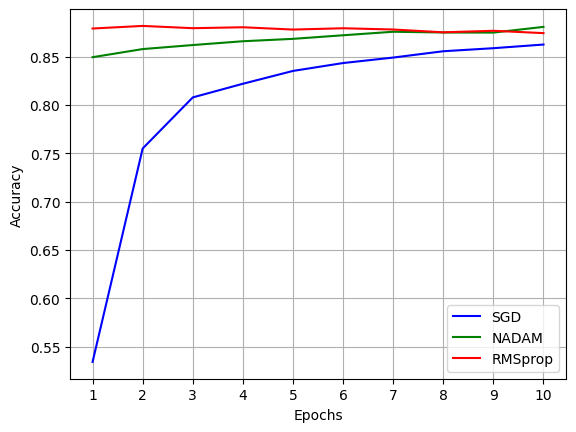

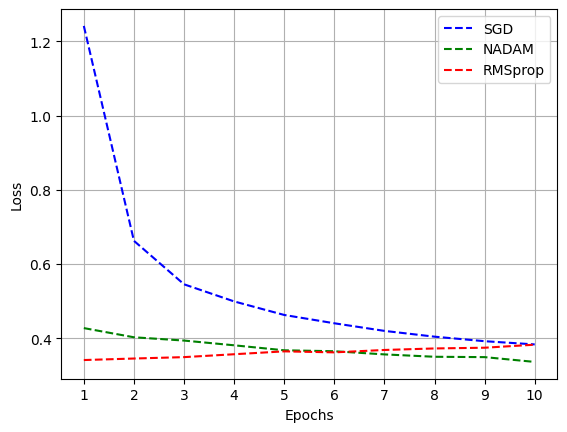

In [9]:
plot_accuracy(accuracies1[0], accuracies1[1], accuracies1[2])
plot_losses(losses1[0], losses1[1], losses1[2])

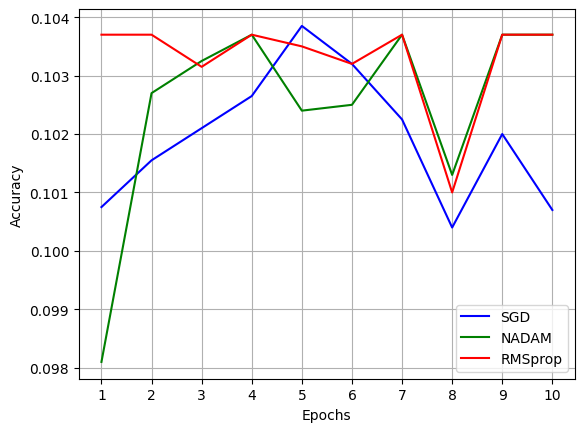

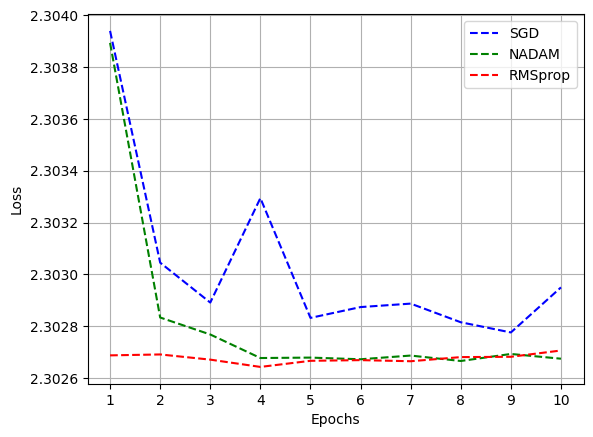

In [10]:
plot_accuracy(accuracies2[0], accuracies2[1], accuracies2[2])
plot_losses(losses2[0], losses2[1], losses2[2])

**Regularization**

In [11]:
def test_kernels_and_regularizers(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, shape, nodeNum):
    accuracies = []
    losses = []

    regularizers = [tf.keras.regularizers.L1(), tf.keras.regularizers.L2()]
    kernels = [tf.keras.initializers.HeNormal(), tf.keras.initializers.LecunNormal()]
    
    for kernel in kernels:
        for regularizer in regularizers:
            tmodel = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape=shape),
                *[tf.keras.layers.Dense(nodeNum, activation='relu', kernel_initializer=kernel, kernel_regularizer=regularizer) for i in range(20)],
                tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal')
            ])
            
            tmodel.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            timeTracker = avgTime()
            
            history = tmodel.fit(x_train, Y_train, validation_data=(x_valid, Y_valid), epochs=10, callbacks=timeTracker, verbose=2)

            _, accuracy = tmodel.evaluate(x_test, Y_test)
            print(f"Kernel: {kernel.__class__.__name__}, Regularizer: {regularizer.__class__.__name__}, Accuracy: {accuracy}, Average Time: {timeTracker.epochsTime}, Max Accuracy: {max(history.history['accuracy'])}, Epoch: {history.history['accuracy'].index(max(history.history['accuracy']))+1}")
            accuracies.append(history.history['accuracy'])
            losses.append(history.history['loss'])

        tmodel = tf.keras.models.Sequential()
        tmodel.add(tf.keras.layers.Flatten(input_shape=shape))
        for i in range(20):
            tmodel.add(tf.keras.layers.Dropout(rate=0.2))
            tmodel.add(tf.keras.layers.Dense(nodeNum, activation='relu', kernel_initializer=kernel))
        tmodel.add(tf.keras.layers.Dropout(rate=0.2))
        tmodel.add(tf.keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
        
        tmodel.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        timeTracker = avgTime()
            
        history = tmodel.fit(x_train, Y_train, validation_data=(x_valid, Y_valid), epochs=10, callbacks=timeTracker, verbose=2)

        _, accuracy = tmodel.evaluate(x_test, Y_test)
        print(f"Kernel: {kernel.__class__.__name__}, Regularizer: Dropout, Accuracy: {accuracy}, Average Time: {timeTracker.epochsTime}, Max Accuracy: {max(history.history['accuracy'])}, Epoch: {history.history['accuracy'].index(max(history.history['accuracy']))+1}")
        accuracies.append(history.history['accuracy'])
        losses.append(history.history['loss'])
    
    return accuracies, losses
            

In [12]:
accuracies3, losses3 = test_kernels_and_regularizers(X_train, X_test, y_train, y_test, X_valid, y_valid, [28, 28], 30)

c:\Users\pceig\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer HeNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
1719/1719 - 20s - loss: 10.1325 - accuracy: 0.5651 - val_loss: 4.2968 - val_accuracy: 0.5586 - 20s/epoch - 11ms/step
Epoch 2/10
1719/1719 - 13s - loss: 3.3367 - accuracy: 0.6607 - val_loss: 2.8503 - val_accuracy: 0.7042 - 13s/epoch - 8ms/step
Epoch 3/10
1719/1719 - 12s - loss: 2.6536 - accuracy: 0.6901 - val_loss: 2.4408 - val_accuracy: 0.7072 - 12s/epoch - 7ms/step
Epoch 4/10
1719/1719 - 14s - loss: 2.3596 - accuracy: 0.7038 - val_loss: 2.2383 - val_accuracy: 0.7192 - 14s/epoch - 8ms/step
Epoch 5/10
1719/1719 - 13s - loss: 2.1959 - accuracy: 0.7089 - val_loss: 2.1434 - val_accuracy: 0.7024 - 13s/epoch - 8ms/step
Epoch 6/10
1719/1719 - 14s - loss: 2.0566 - accuracy: 0.7152 - val_loss: 1.9929 - val_accuracy: 0.7176 - 14s/epoch - 8ms/step
Epoch 7/10
1719/1719 - 14s - loss: 1.9558 - accuracy: 0.7152 - val_loss: 1.9420 - val_accuracy: 0.7150 - 14s/epoch - 8ms/step
Epoch 8/10
1719/1719 - 14s - loss: 1.8697 - accuracy: 0.7174 - val_loss: 1.8344 - val_accuracy: 0.7166 - 14s/epoch -

c:\Users\pceig\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer LecunNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/10
1719/1719 - 20s - loss: 4.1795 - accuracy: 0.1000 - val_loss: 2.3393 - val_accuracy: 0.0914 - 20s/epoch - 12ms/step
Epoch 2/10
1719/1719 - 13s - loss: 2.3390 - accuracy: 0.0972 - val_loss: 2.3388 - val_accuracy: 0.0914 - 13s/epoch - 8ms/step
Epoch 3/10
1719/1719 - 13s - loss: 2.3390 - accuracy: 0.0980 - val_loss: 2.3391 - val_accuracy: 0.1008 - 13s/epoch - 7ms/step
Epoch 4/10
1719/1719 - 13s - loss: 2.3389 - accuracy: 0.0985 - val_loss: 2.3386 - val_accuracy: 0.1008 - 13s/epoch - 7ms/step
Epoch 5/10
1719/1719 - 13s - loss: 2.3389 - accuracy: 0.0985 - val_loss: 2.3392 - val_accuracy: 0.0986 - 13s/epoch - 7ms/step
Epoch 6/10
1719/1719 - 14s - loss: 2.3389 - accuracy: 0.0998 - val_loss: 2.3386 - val_accuracy: 0.0980 - 14s/epoch - 8ms/step
Epoch 7/10
1719/1719 - 13s - loss: 2.3389 - accuracy: 0.1004 - val_loss: 2.3391 - val_accuracy: 0.1012 - 13s/epoch - 8ms/step
Epoch 8/10
1719/1719 - 13s - loss: 2.3389 - accuracy: 0.0997 - val_loss: 2.3386 - val_accuracy: 0.0914 - 13s/epoch - 

In [13]:
accuracies4, losses4 = test_kernels_and_regularizers(cX_train, cX_test, cy_train, cy_test, cX_valid, cy_valid, [32, 32, 3], 50)

Epoch 1/10
625/625 - 17s - loss: 31.6969 - accuracy: 0.0954 - val_loss: 8.4064 - val_accuracy: 0.1038 - 17s/epoch - 28ms/step
Epoch 2/10
625/625 - 10s - loss: 5.1017 - accuracy: 0.1032 - val_loss: 3.3215 - val_accuracy: 0.1038 - 10s/epoch - 16ms/step
Epoch 3/10
625/625 - 10s - loss: 2.8289 - accuracy: 0.1029 - val_loss: 2.5689 - val_accuracy: 0.1038 - 10s/epoch - 16ms/step
Epoch 4/10
625/625 - 11s - loss: 2.5091 - accuracy: 0.1034 - val_loss: 2.4822 - val_accuracy: 0.1038 - 11s/epoch - 18ms/step
Epoch 5/10
625/625 - 10s - loss: 2.4783 - accuracy: 0.1027 - val_loss: 2.4777 - val_accuracy: 0.1038 - 10s/epoch - 17ms/step
Epoch 6/10
625/625 - 11s - loss: 2.4783 - accuracy: 0.1024 - val_loss: 2.4791 - val_accuracy: 0.1038 - 11s/epoch - 17ms/step
Epoch 7/10
625/625 - 10s - loss: 2.4798 - accuracy: 0.1037 - val_loss: 2.4802 - val_accuracy: 0.1038 - 10s/epoch - 16ms/step
Epoch 8/10
625/625 - 11s - loss: 2.4806 - accuracy: 0.1015 - val_loss: 2.4809 - val_accuracy: 0.1038 - 11s/epoch - 17ms/step

In [14]:
def plot_accuracy2(acc1, acc2, acc3, acc4, acc5, acc6):
    epochs = range(1, len(acc1) + 1)
    plt.plot(epochs, acc1, label='He+L1', color='b')
    plt.plot(epochs, acc2, label='He+L2', color = 'g')
    plt.plot(epochs, acc3, label='He+Drop', color = 'r')
    plt.plot(epochs, acc4, label='LC+L1', color = 'c')
    plt.plot(epochs, acc5, label='LC+L2', color = 'k')
    plt.plot(epochs, acc6, label='LC+Drop', color = 'm')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_losses2(loss1, loss2, loss3, loss4, loss5, loss6):
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, label='He+L1', color = 'b', linestyle='--')
    plt.plot(epochs, loss2, label='He+L2', color = 'g', linestyle='--')
    plt.plot(epochs, loss3, label='He+Drop', color = 'r', linestyle='--')
    plt.plot(epochs, loss4, label='LC+L1', color = 'c', linestyle='--')
    plt.plot(epochs, loss5, label='LC+L2', color = 'k', linestyle='--')
    plt.plot(epochs, loss6, label='LC+Drop', color = 'm', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

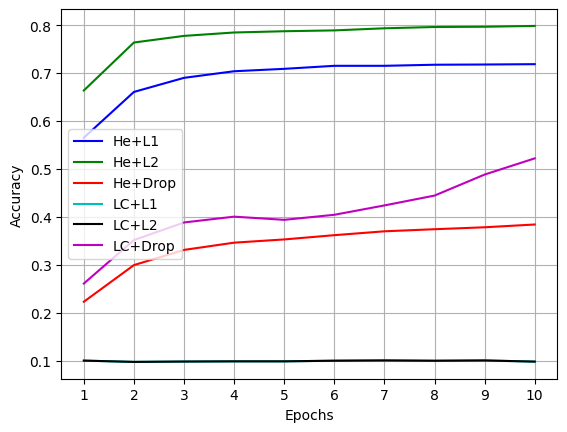

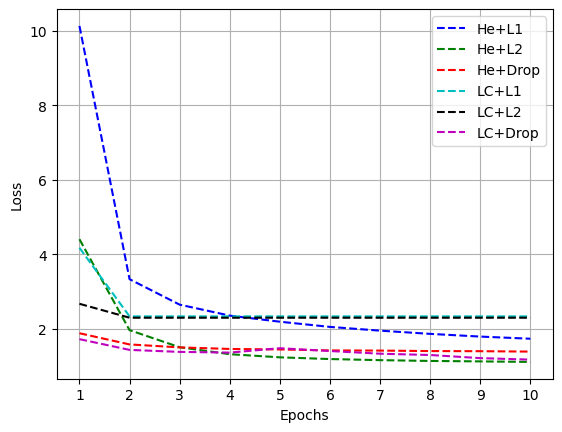

In [15]:
plot_accuracy2(accuracies3[0], accuracies3[1], accuracies3[2], accuracies3[3], accuracies3[4], accuracies3[5])
plot_losses2(losses3[0], losses3[1], losses3[2], losses3[3], losses3[4], losses3[5])

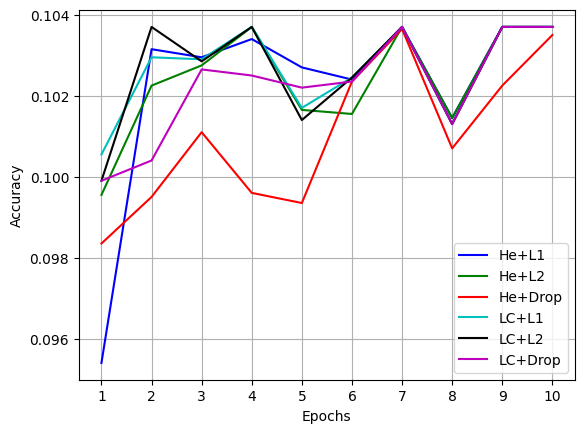

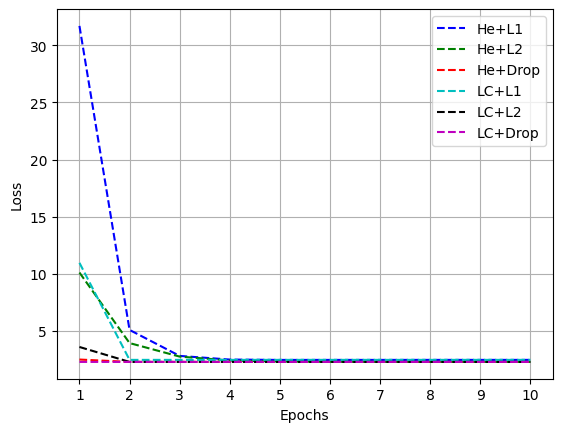

In [16]:
plot_accuracy2(accuracies4[0], accuracies4[1], accuracies4[2], accuracies4[3], accuracies4[4], accuracies4[5])
plot_losses2(losses4[0], losses4[1], losses4[2], losses4[3], losses4[4], losses4[5])

In [17]:
def test_paths(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, shape):
    accuracies = []
    losses = []

    timeTracker = avgTime()

    def makeModel(ahhh):
        flatten_layer = tf.keras.layers.Flatten(input_shape=shape)

        dl1 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl2 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl3 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl4 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl5 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl6 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl7 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl8 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl9 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl10 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl11 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl12 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl13 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl14 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl15 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl16 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl17 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl18 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl19 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")
        dl20 = tf.keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")

        w1l1 = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2")
        w1l2 = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2")
        w1l3 = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2")
        w1l4 = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2")
        w1l5 = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal", kernel_regularizer="l2")

        concat_layer = tf.keras.layers.Concatenate()

        output_layer = tf.keras.layers.Dense(10, activation="softmax", kernel_initializer="glorot_normal")

        input_ = tf.keras.layers.Input(shape=shape)
        flatten = flatten_layer(input_)

        l1 = dl1(flatten)
        l2 = dl2(l1)
        l3 = dl3(l2)
        l4 = dl4(l3)
        l5 = dl5(l4)
        l6 = dl6(l5)
        l7 = dl7(l6)
        l8 = dl8(l7)
        l9 = dl9(l8)
        l10 = dl10(l9)
        l11 = dl11(l10)
        l12 = dl12(l11)
        l13 = dl13(l12)
        l14 = dl14(l13)
        l15 = dl15(l14)
        l16 = dl16(l15)
        l17 = dl17(l16)
        l18 = dl18(l17)
        l19 = dl19(l18)
        l20 = dl20(l19)

        wl1 = w1l1(flatten)
        wl2 = w1l2(wl1)
        wl3 = w1l2(wl2)
        wl4 = w1l2(wl3)
        wl5 = w1l2(wl4)

        if ahhh == "r":
            concat = concat_layer([l20, wl5])
            output_ = output_layer(concat)
            tmodel = tf.keras.Model(inputs = [input_], outputs= [output_])
            return tmodel

        if ahhh == "e":
            concat = concat_layer([l20, flatten])
            output_ = output_layer(concat)
            tmodel = tf.keras.Model(inputs = [input_], outputs= [output_])
            return tmodel

        if ahhh == "n":
            output_ = output_layer(l20)
            tmodel = tf.keras.Model(inputs = [input_], outputs= [output_])
            return tmodel


    def runModel(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, tmodel, accuracies, losses, ah2):

        tmodel.compile(optimizer='nadam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = tmodel.fit(x_train, Y_train, epochs=10, validation_data=(x_valid, Y_valid), verbose=0, callbacks=[timeTracker])
        _, accuracy = tmodel.evaluate(x_test, Y_test, verbose=0)
        print(f"Model: {ah2} Wide, Accuracy: {accuracy}, Average Time: {timeTracker.epochsTime}, Max Accuracy: {max(history.history['accuracy'])}, Epoch: {history.history['accuracy'].index(max(history.history['accuracy']))+1}")
        accuracies.append(history.history['accuracy'])
        losses.append(history.history['loss'])


    tmodel = makeModel("r")
    runModel(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, tmodel, accuracies, losses, "Regularized")
    tmodel = makeModel("e")
    runModel(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, tmodel, accuracies, losses, "Empty")
    tmodel = makeModel("n")
    runModel(x_train, x_test, Y_train, Y_test, x_valid, Y_valid, tmodel, accuracies, losses, "No")

    return accuracies, losses

In [18]:
accuracies5, losses5 = test_paths(X_train, X_test, y_train, y_test, X_valid, y_valid, [28, 28])

Model: Regularized Wide, Accuracy: 0.8507999777793884, Average Time: 20.67425956726074, Max Accuracy: 0.8669090867042542, Epoch: 10
Model: Empty Wide, Accuracy: 0.8604999780654907, Average Time: 17.481054997444154, Max Accuracy: 0.8814727067947388, Epoch: 10
Model: No Wide, Accuracy: 0.8575000166893005, Average Time: 16.064399337768556, Max Accuracy: 0.8722000122070312, Epoch: 10


In [19]:
accuracies6, losses6 = test_paths(cX_train, cX_test, cy_train, cy_test, cX_valid, cy_valid, [32, 32, 3])

Model: Regularized Wide, Accuracy: 0.10000000149011612, Average Time: 12.467272233963012, Max Accuracy: 0.10369999706745148, Epoch: 7
Model: Empty Wide, Accuracy: 0.09009999781847, Average Time: 11.126316678524017, Max Accuracy: 0.14329999685287476, Epoch: 9
Model: No Wide, Accuracy: 0.10000000149011612, Average Time: 10.18769010702769, Max Accuracy: 0.10369999706745148, Epoch: 7


In [20]:
def plot_accuracy3(acc1, acc2, acc3):
    epochs = range(1, len(acc1) + 1)
    plt.plot(epochs, acc1, label='Reg', color='b')
    plt.plot(epochs, acc2, label='Empty', color = 'g')
    plt.plot(epochs, acc3, label='None', color = 'r')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_losses3(loss1, loss2, loss3):
    epochs = range(1, len(loss1) + 1)
    plt.plot(epochs, loss1, label='Reg', color = 'b', linestyle='--')
    plt.plot(epochs, loss2, label='Empty', color = 'g', linestyle='--')
    plt.plot(epochs, loss3, label='None', color = 'r', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.grid(True)
    plt.legend()
    plt.show()

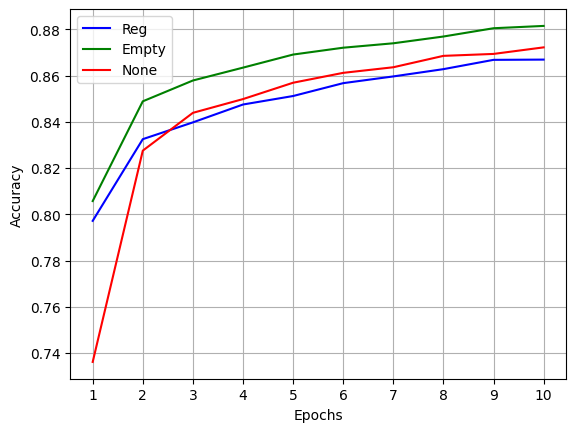

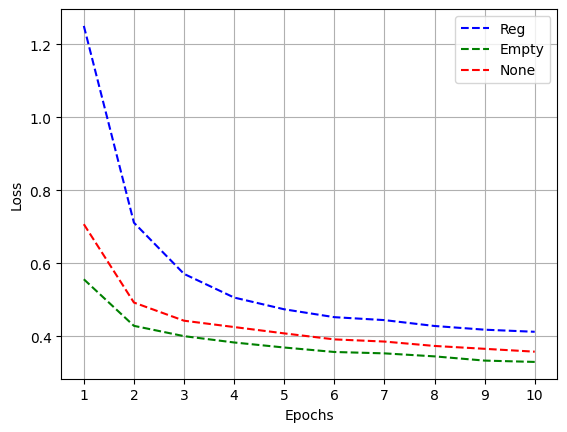

In [21]:
plot_accuracy3(accuracies5[0], accuracies5[1], accuracies5[2])
plot_losses3(losses5[0], losses5[1], losses5[2])

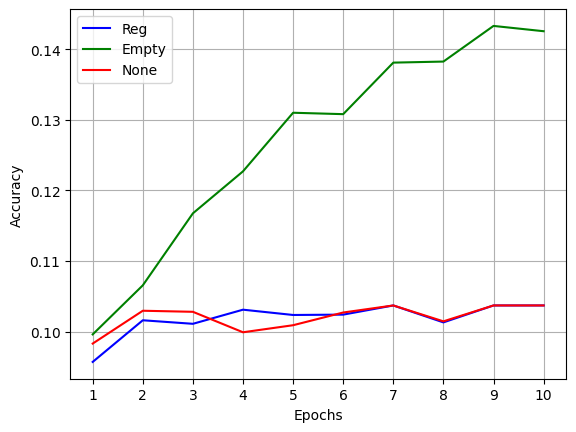

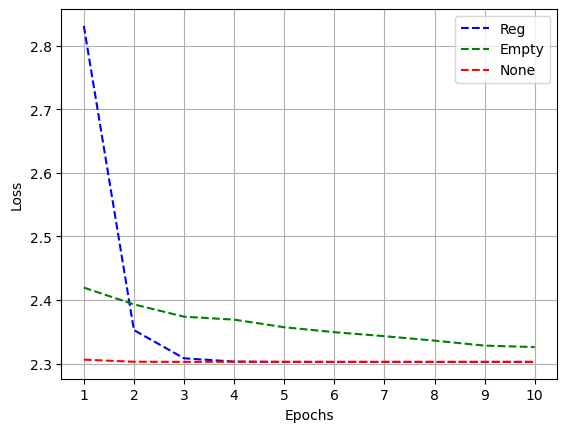

In [22]:
plot_accuracy3(accuracies6[0], accuracies6[1], accuracies6[2])
plot_losses3(losses6[0], losses6[1], losses6[2])